In [ ]:
import numpy as np
import platform
import tempfile
import os
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
# necessite scikit-image 
from skimage import io as skio
import time

# POUR LA MORPHO
from skimage.morphology import watershed 
from skimage.feature import peak_local_max


In [ ]:
import cv2
import os
from PIL import Image
import pickle
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [ ]:
from skimage import io as skio

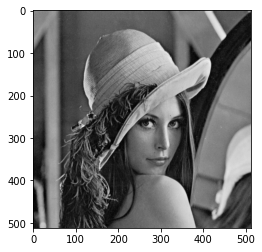

In [ ]:
im=skio.imread('lena.tif')
plt.figure('Image originale')
plt.imshow(im, cmap='gray')

In [ ]:
def  grady(I):
    """ Calcule le gradient en y de l'image I, avec condition de vonnewman au bord
     i.e. l'image est symétrisée et le gradient en bas est nul"""
    
    (m,n)=I.shape
    M=np.zeros((m,n))
    M[:-1,:]=-I[:-1,:]+I[1:,:]
    M[-1,:]=np.zeros((n,))
    return M

def  gradx(I):
    """ Calcule le gradient en y de l'image I, avec condition de vonnewman au bord
     i.e. l'image est symétrisée et le gradient a droite est nul"""
    
    (m,n)=I.shape
    M=np.zeros((m,n))
    M[:,:-1]=-I[:,:-1]+I[:,1:]
    M[:,-1]=np.zeros((m,))
    return M

def prodscal(a,b):
    return (a*b).sum()

def prodscal_c(a,b):
    return ((a[0]*b[0]+a[1]*b[1])).sum()


gy=grady(im)
gx=gradx(im)
print('gx=',gx[0,50])
print('gy=',gy[0,50])

#print (prodscal(div(px,py),im))
#print (prodscal_c((px,py),(gx,gy)))

gx= 11.0
gy= 0.0


In [ ]:
def normeGradient(gradx,grady):
  
    return (gradx**2+grady**2)**0.5

In [ ]:
def Sn(im1,im2):
    g1x=gradx(im1)
    g2x=gradx(im2)
    g1y=grady(im1)
    g2y=grady(im2)
    module_grad_im1= normeGradient(g1x,g1y)
    module_grad_im2= normeGradient(g2x,g2y)
    d=np.sqrt(module_grad_im1 *module_grad_im1 + module_grad_im2*module_grad_im2)
    epsilon=0.000001
    return module_grad_im1/(d+epsilon)

In [ ]:
im1= np.float32(skio.imread('lena_f1.tif'))
im2=np.float32(skio.imread('lena_f2.tif'))
t0=time.time()
Sn(im1,im2)
t1=time.time()-t0
print ('temps de calcul de Sn',t1,im1.shape)


temps de calcul de Sn 0.027081012725830078 (512, 512)


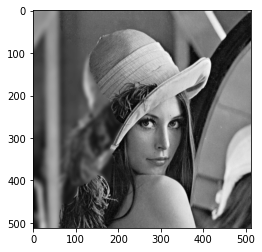

In [ ]:
plt.imshow(im1, cmap='gray')

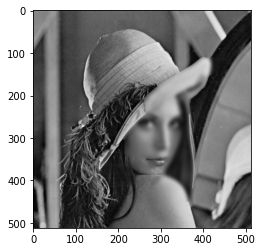

In [ ]:
plt.imshow(im2, cmap='gray')

In [ ]:
def Gs(im1,im2):
    (dy,dx)=im1.shape
    out=np.zeros((dy,dx,2,2))
    gradx_1 =gradx(im1)
    gradx_2 =gradx(im2)
    grady_1 =grady(im1)
    grady_2 =grady(im2)
    s1=Sn(im1,im2)
    s2=Sn(im2,im1)
    a = s1*s1*gradx_1**2 + s2*s2*gradx_2**2
    b = s1*s1*gradx_1*grady_1 + s2*s2*gradx_2*grady_2
    c=b
    d = s1*s1*grady_1**2 + s2*s2*grady_2**2
    out[:,:,0,0]=a
    out[:,:,1,0]=b
    out[:,:,0,1]=c
    out[:,:,1,1]=d 

    return out
   

In [ ]:
t0=time.time()
Gs(im1,im2)
print(time.time()-t0)

0.07049751281738281


In [ ]:
G=Gs(im1,im2)
v, P = np.linalg.eig(G)
print(v.shape,P.shape)
print((np.argmax(v,axis=2)).shape)

(512, 512, 2) (512, 512, 2, 2)
(512, 512)


In [ ]:
v0=np.asarray([1,2,4]).reshape((-1,1))
M=v0@v0.T
print(M)
lams,pp=np.linalg.eig(M)
print(lams,pp[:,0],pp[:,0])
#help(np.expand_dims)
#M=np.expand_dims(M,axis=2)
#print(M.shape)

[[ 1  2  4]
 [ 2  4  8]
 [ 4  8 16]]
[ 2.10000000e+01  1.97215226e-31 -9.15077010e-17] [0.21821789 0.43643578 0.87287156] [0.21821789 0.43643578 0.87287156]


In [ ]:
def V(im1,im2):
    G=Gs(im1,im2)
    S1=Sn(im1,im2)
    S2=Sn(im2,im1)
    g1x=gradx(im1)
    g1y=grady(im1)
    g2x=gradx(im2)
    g2y=grady(im2)
    print (G.shape)
    v, P = np.linalg.eig(G)
    imax = np.argmax(np.abs(v),axis=2)    #la valeur propre maximale 
    print(imax.shape)
    vec_propre=np.zeros((*im1.shape,2))
    val_propre=np.zeros(im1.shape)
    for y in range(P.shape[0]):
      for x in range(P.shape[1]):
        vec_propre[y,x,:]=P[y,x, :, imax[y,x]]
        val_propre[y,x]=v[y,x,imax[y,x]]
    vec_sommex=S1*g1x+S2*g2x
    vec_sommey=S1*g2y+S2*g2y

    signe = np.sign((vec_sommex*vec_propre[:,:,0]+vec_sommey*vec_propre[:,:,1]))
    signe=np.expand_dims(signe,axis=2)
    #plt.imshow(val_propre,cmap='gray')
    return (np.expand_dims(np.sqrt(val_propre),axis=2)  * vec_propre * signe)
     

(512, 512, 2, 2)
(512, 512)


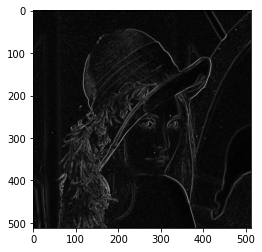

In [ ]:
Vs=V(im1,im2)   
plt.imshow(normeGradient(Vs[:,:,0],Vs[:,:,1]),cmap='gray')# composante x
#plt.imshow(np.abs(Vs[:,:,1]))#composante y

##FIN MODIFICATION LADJAL

In [ ]:
Vs.shape

(512, 512, 2)

In [ ]:
def Dv(I,im1,im2):
    Vs=V(im1,im2) 
    gx=gradx(I)
    gy=grady(I)
    return np.sum(np.sum((gx-Vs[:,:,0])**2 + (gy-Vs[:,:,1])**2,axis=0),axis=0) # deja positive donc on peut enlever sqrt, abs , carrr
 

In [ ]:
Dv(im1,im1,im1)

(512, 512, 2, 2)
(512, 512)


1.250619518971435e-07

In [ ]:
def D(I,im1,im2):
    I0 = 0.5*(im1 + im2)
    return np.sum(np.sum((I-I0)**2,axis=0),axis=0)
   

In [ ]:
D(im1,im2,im1)

9921866.0

In [ ]:
##################### On a un probleme ICi############################################################################
def W(x,y):
    a=4 # a= 4 ou 5
    norme=((x[0]-y[0])**2+(x[1]-y[1])**2)/(2*a)

    return (np.exp(-norme))
# si on va mettre sous forme d'un matrice donc on va avoir un matrice 3D de taille 255,255,255^2

In [ ]:
def J(I,x,y):                  # fonction d'activation sigmode function
    a = 1 ## alpha
    k=1 ## on va voir est ce que on peut la changer
    return k*np.arctan(a*(I[x[0],x[1]]-I[y[0],y[1]]))
################################################################################################################################""

In [ ]:
def C(I):               # problmee a cause de w et j
    s=0
    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            for k in range(I.shape[0]):
                for h in range(I.shape[1]):
                    w=W([i,j],[k,h])
                    #s+= w*J(I,[i,j],[k,h])   
    return s 

In [ ]:
b=np.array([[[1,2],[1,2],[1,2]],[[1,2],[1,2],[1,2]],[[1,2],[1,2],[1,2]]])
b.shape


(3, 3, 2)

In [ ]:
def E_tilde(im1,im2,I):
    etta=0.1 # etta
    gamma= 0.3 # gamma
    return (etta*Dv(im1,im2,I)+gamma*D(I,im1,im2))#-C(I))   probleme au w et j

In [ ]:
E_tilde(im1,im1,im1)

(512, 512, 2, 2)
(512, 512)


1.2506195189714349e-08

In [ ]:
def R(K,I) :                                 # probleme ici a cause de w et 
  for i in range (I.shape[0]): 
    for j in range (I.shape[1]):
      w = W(x,[i,j])
      r+=w*atan(I[x]-I[i,j])
  
  return (2*r)

In [ ]:
def div(px,py): 
    """calcule la divergens d'un champ de gradient"""
    """ div= - (grad)^*, i.e. div est la transposee de l'operateur gradient"""
    (m,n)=px.shape 
    assert px.shape==py.shape , " px et py n'ont pas la meme taille dans div"
    M=np.zeros((m,n))
    Mx=np.zeros((m,n))
    My=np.zeros((m,n))
    
    My[1:-1,:]=py[1:-1,:]-py[:-2,:]
    My[0,:]=py[0,:]
    My[-1,:]=-py[-2,:]
    
    Mx[:,1:-1]=px[:,1:-1]-px[:,:-2]
    Mx[:,0]=px[:,0]
    Mx[:,-1]=-px[:,-2]
    return Mx+My

In [ ]:
a = np.zeros((1,255))
a.shape[0]


1

In [ ]:
def laplacien(I):
  I1=np.append(I[1:,:],np.zeros((1,I.shape[1])),axis=0)
  I2=np.append(np.zeros((1,I.shape[1])),I[:I.shape[0]-1,:],axis=0)
  I3=np.append(I[:,1:],np.zeros((I.shape[0],1)),axis=1)
  I4=np.append(np.zeros((I.shape[0],1)),I[:,:I.shape[1]-1],axis=1) 
  return(I1+I2+I3+I4-4*I)



In [ ]:
laplacien(im1)

array([[-272., -136., -136., ..., -165., -143., -167.],
       [-136.,    0.,   -1., ...,  -17.,  -13.,  -68.],
       [-137.,   -2.,    2., ...,  -17.,  -13.,  -68.],
       ...,
       [ -24.,   -2.,    1., ...,  -17.,    1.,  -43.],
       [ -25.,    2.,   -1., ...,    0.,   -1.,  -89.],
       [ -50.,  -24.,  -27., ...,  -73.,  -69., -151.]])

In [ ]:
def gradient_descent(I,I0): # I = Ik (precedente); I0 = im1+im2 /2
  gamma=0.3
  betta = 0.5
  etta=0.1
  delta_t=0.15
  L = laplacien(I)
  R = 0 # probleme au w et j donc....
  return ((1-2*(gamma+betta)*delta_t)*I+2*etta*(L-div(Vs[:,:,0],Vs[:,:,1]))*delta_t + (betta + 2*gamma*I0 + R)*delta_t)
  




In [ ]:
gradient_descent(im1,im1)

array([[107.5150021 , 111.5950021 , 111.62500207, ..., 121.43499714,
        106.67499599,  78.2849985 ],
       [111.5950021 , 115.6750021 , 115.66621529, ..., 125.87499714,
        110.57499599,  81.2549985 ],
       [111.5650021 , 115.67500206, 114.88499885, ..., 125.87499714,
        110.57499599,  81.2549985 ],
       ...,
       [ 20.34149614,  21.5769861 ,  22.50341966, ...,  62.12500042,
         57.87500096,  50.9149992 ],
       [ 20.69141736,  21.20587205,  22.71230004, ...,  59.57500125,
         60.4249997 ,  60.75499843],
       [ 19.82500029,  20.30647423,  21.78352645, ...,  57.47500124,
         58.29499971,  58.53499845]])

In [ ]:
#programme principale 

I=Sn(im1,im2)*im1 + Sn(im2,im1)*im2
I0=0.5*(im1+im2)
L_images_sortie=[];
L_E_tilde_sortie =[];
for i in range(100):
  I = gradient_descent(I,I0)
  L_images_sortie.append(I)
  E_t=E_tilde(im1,im2,I)
  L_E_tilde_sortie.append(E_t)
I_fusione = L_images_sortie[L_E_tilde_sortie.index(min(L_E_tilde_sortie))]

(512, 512, 2, 2)
(512, 512)
(512, 512, 2, 2)
(512, 512)
(512, 512, 2, 2)
(512, 512)
(512, 512, 2, 2)
(512, 512)
(512, 512, 2, 2)
(512, 512)
(512, 512, 2, 2)
(512, 512)
(512, 512, 2, 2)
(512, 512)
(512, 512, 2, 2)
(512, 512)
(512, 512, 2, 2)
(512, 512)
(512, 512, 2, 2)
(512, 512)
(512, 512, 2, 2)
(512, 512)
(512, 512, 2, 2)
(512, 512)
(512, 512, 2, 2)
(512, 512)
(512, 512, 2, 2)
(512, 512)
(512, 512, 2, 2)
(512, 512)
(512, 512, 2, 2)
(512, 512)
(512, 512, 2, 2)
(512, 512)
(512, 512, 2, 2)
(512, 512)
(512, 512, 2, 2)
(512, 512)
(512, 512, 2, 2)
(512, 512)
(512, 512, 2, 2)
(512, 512)
(512, 512, 2, 2)
(512, 512)
(512, 512, 2, 2)
(512, 512)
(512, 512, 2, 2)
(512, 512)
(512, 512, 2, 2)
(512, 512)
(512, 512, 2, 2)
(512, 512)
(512, 512, 2, 2)
(512, 512)
(512, 512, 2, 2)
(512, 512)
(512, 512, 2, 2)
(512, 512)
(512, 512, 2, 2)
(512, 512)
(512, 512, 2, 2)
(512, 512)
(512, 512, 2, 2)
(512, 512)
(512, 512, 2, 2)
(512, 512)
(512, 512, 2, 2)
(512, 512)
(512, 512, 2, 2)
(512, 512)
(512, 512, 2, 2)
(51

In [ ]:
L_E_tilde_sortie.index(min(L_E_tilde_sortie))

1

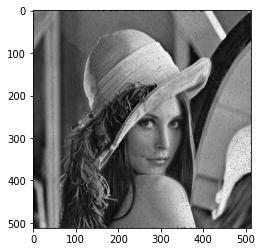

In [ ]:
I_fusione.shape
plt.imshow(I_fusione,cmap='gray')